<a href="https://colab.research.google.com/github/Artem1s1337/getting_started/blob/one/housing_prices_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируемые библиотеки
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"artemiymccormick","key":"fac7ba0f9b25f335dd5922e0f0055841"}'}

In [3]:
!mkdir -p ~/.kaggle  # создание директории для API ключа
!cp kaggle.json ~/.kaggle/  # копирование json в директорию
!chmod 600 ~/.kaggle/kaggle.json  # защита API ключа

In [4]:
!kaggle competitions download -c home-data-for-ml-course  # скачиваем соревнование

  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 187MB/s]


In [5]:
!mkdir /content/houses_data  # создаём папку
!unzip home-data-for-ml-course.zip -d houses_data  # распаковываем данные в папку

Archive:  home-data-for-ml-course.zip
  inflating: houses_data/data_description.txt  
  inflating: houses_data/sample_submission.csv  
  inflating: houses_data/sample_submission.csv.gz  
  inflating: houses_data/test.csv    
  inflating: houses_data/test.csv.gz  
  inflating: houses_data/train.csv   
  inflating: houses_data/train.csv.gz  


# Frame the problem
Цель - предсказать цену домов на основе n-признаков. Это задача supervised learning, а точнее регрессия. Таргет-метрика - **SalePrice**. Эффективность модели будет измеряться по RMSE (root-mean-squared-error), среднеквадратичной ошибке. При этом берётся она по логарифму предсказания и таргета, чтобы RMSE результаты для дорогих и дешёвых домов оценивались одинаково.

In [6]:
# Загрузим данные и изучим основную информацию
folder = 'houses_data/'
iowa_train = pd.read_csv(folder + 'train.csv')
iowa_test = pd.read_csv(folder + 'test.csv')

In [7]:
iowa_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
iowa_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [9]:
print(iowa_train.shape, iowa_test.shape)

(1460, 81) (1459, 80)


In [10]:
sample_sub = pd.read_csv(folder + 'sample_submission.csv')
sample_sub.shape

(1459, 2)

Видно, что много категориальных признаков, значит необходимо копнуть глубже в них

In [12]:
# Разделим данные на числовые и категориальные признкаи
num_iowa = X.select_dtypes(include=np.number)
cat_iowa = X.select_dtypes(include=object)

In [13]:
miss_num = num_iowa.isna().sum()
num_not_na = num_iowa.notna().sum()
miss_num[miss_num.iloc[:] > 0] / num_not_na[miss_num.iloc[:] > 0]

,0
LotFrontage,0.215654
MasVnrArea,0.005510
GarageYrBlt,0.058738


array([[<Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'MasVnrArea'}>],
       [<Axes: title={'center': 'GarageYrBlt'}>, <Axes: >]], dtype=object)

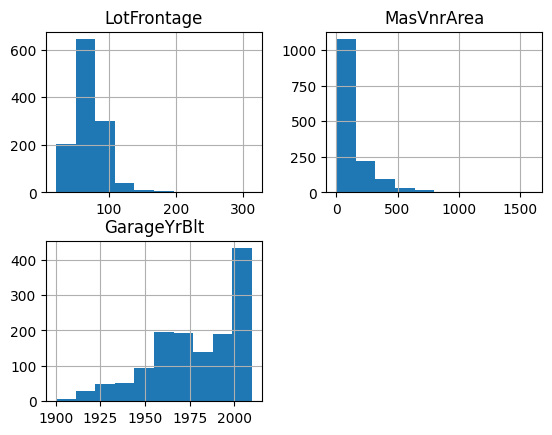

In [14]:
num_iowa[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist()

In [15]:
num_iowa[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].describe()

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000


In [16]:
# Заполним медианными значениями пропуски в числовых колнках
cols = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
for c in cols:
    num_iowa[c] = num_iowa[c].fillna(num_iowa[c].median())

num_iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [17]:
# Или через imputer
from sklearn.impute import SimpleImputer

num_dtypes = num_iowa.dtypes.to_dict()  # сохраним оригинальный тип данных

# Создадим эстиматор imputer с заполнением медианой
imputer = SimpleImputer(strategy='median')
num_imputer = imputer.fit_transform(num_iowa)

# Вернём датафрейм с заполненными значениями
num_iowa = pd.DataFrame(num_imputer, columns=num_iowa.columns, index=num_iowa.index).astype(num_dtypes)

num_iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [18]:
# Рассмотрим категориальные признаки по той же схеме
miss_cat = cat_iowa.isna().sum()
miss_cat = miss_cat[miss_cat.iloc[:] > 0]
total = len(cat_iowa)

miss_percent = (miss_cat / total).sort_values(ascending=False)
miss_percent

,0
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
GarageFinish,0.055479
GarageQual,0.055479
GarageType,0.055479
GarageCond,0.055479


6 признаков имеют процент пропущенных значений >= 47%, а это значит, что при моделировании они будут неэффективными. Удалим эти колонки из общей выборки

In [19]:
threshold = total * 0.53  # колонки, в которых не NaN значений 53% и ниже
cat_iowa.dropna(axis=1, thresh=threshold, inplace=True)

In [20]:
miss_cat = cat_iowa.isna().sum()
miss_cat = miss_cat[miss_cat.iloc[:] > 0]
cat_miss = miss_cat.index.to_list()  # отберём оставшиеся колонки списком

# Заполним NaN самыми частыми значениями
imputer_cat = SimpleImputer(strategy='most_frequent')
cat_imputer = imputer_cat.fit_transform(cat_iowa)

cat_iowa = pd.DataFrame(cat_imputer, columns=cat_iowa.columns, index=cat_iowa.index)

In [21]:
cat_iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  ExterQual      1460 non-null   object
 17  ExterCond      1460 non-null   object
 18  Foundation     1460 non-null

In [22]:
num_iowa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

# Корреляция и визуализация числовых признаков

<Axes: >

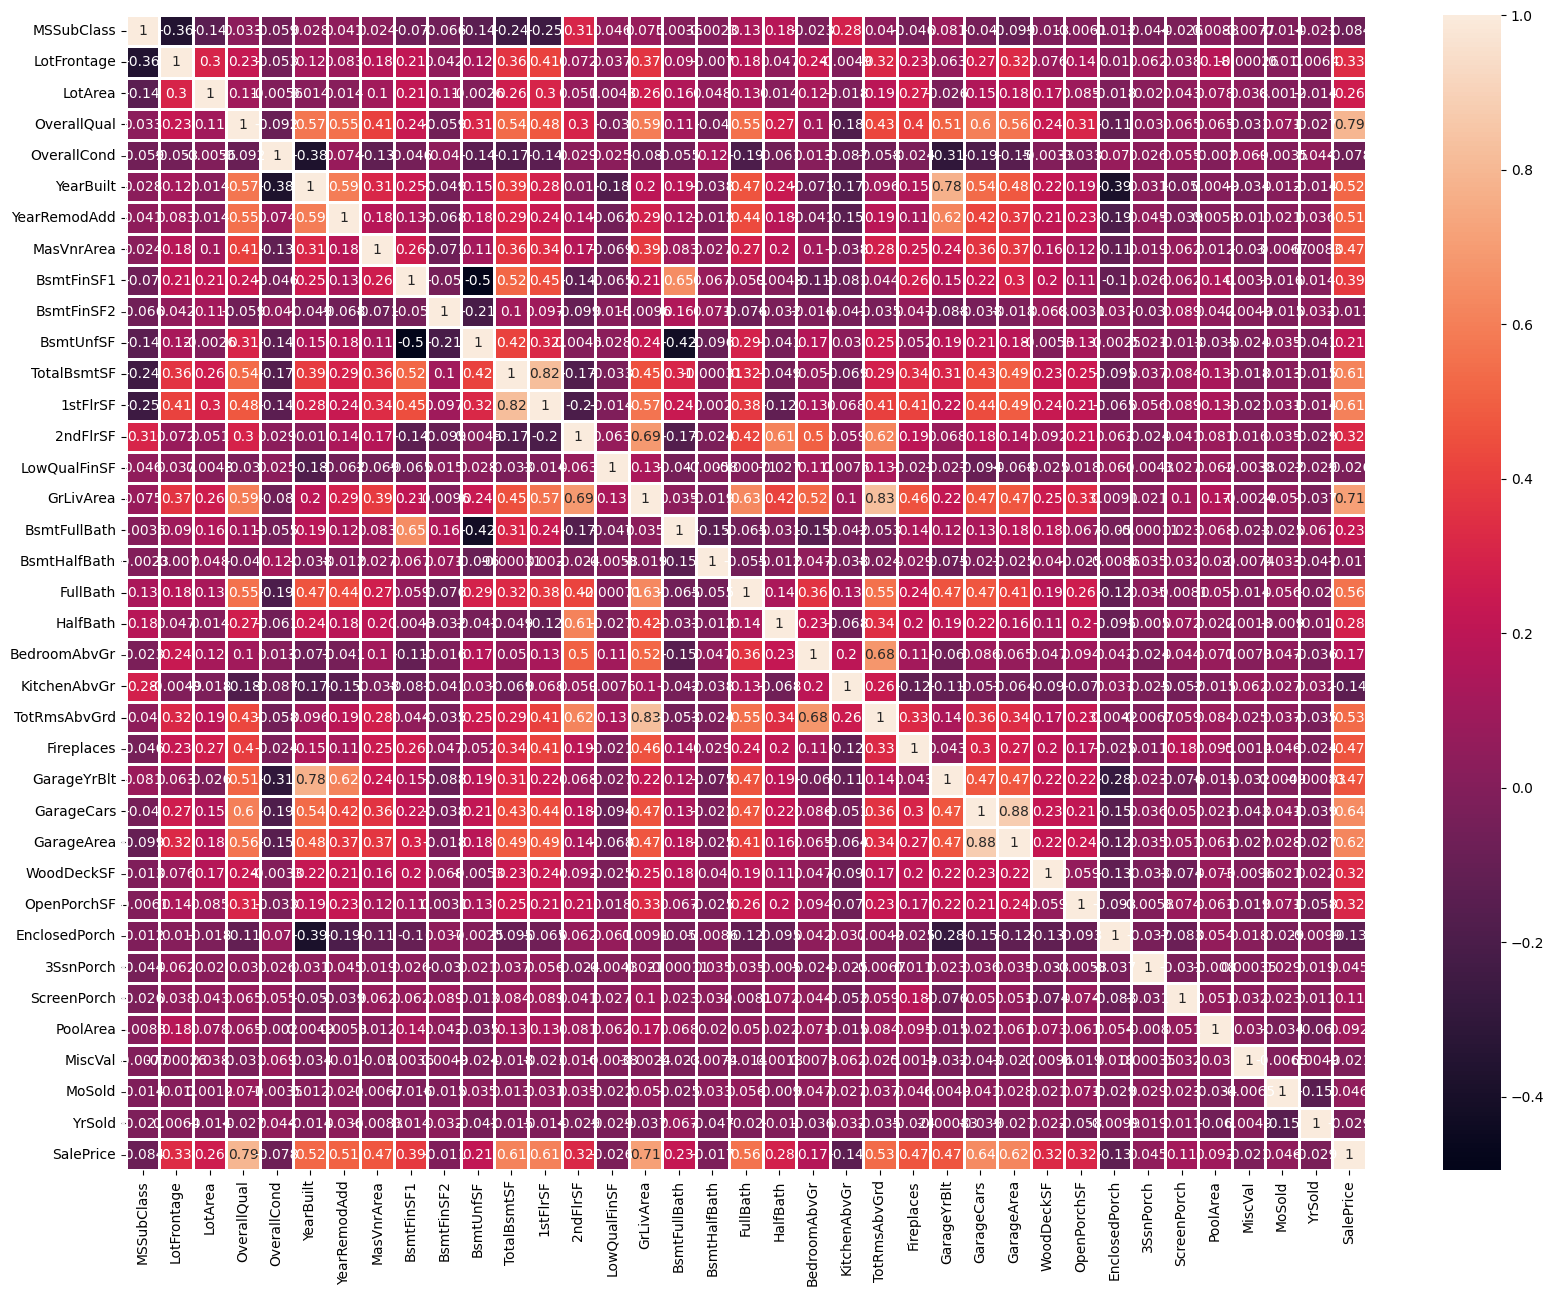

In [23]:
num_corr = pd.concat([num_iowa, y], axis=1)
n = num_corr.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(n, annot=True, linewidths=0.8, )

Соответственно отберём признаки с сильной линейной корреляцией:
- OverallCond - категориальный числовой признак
- YearBuilt
- GrLivArea
- FullBath
- TotRmsAbvGrd
- Fireplaces

In [24]:
from sklearn import set_config
set_config(display='diagram')

In [25]:
# num_iowa['OverallCond'].unique()

num_selection = num_iowa[['OverallCond', 'YearBuilt', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']]

# Применим OrdinalEncoder(), т.к. это оценки состояния: чем они выше, тем дороже дом
from sklearn.preprocessing import OrdinalEncoder

cond_encoder = OrdinalEncoder()
cond = num_selection[['OverallCond']]
cond = cond_encoder.fit_transform(cond)
cond = pd.DataFrame(cond)

In [26]:
cond[0].unique()

array([4., 7., 5., 6., 3., 1., 2., 8., 0.])

In [27]:
num_selection['OverallCond'].unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1])

In [28]:
num_selection.drop('OverallCond', axis=1, inplace=True)
num_selection = pd.concat([num_selection, cond], axis=1)

/tmp/ipython-input-835651540.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_selection.drop('OverallCond', axis=1, inplace=True)


In [29]:
num_selection.rename(columns={0: 'OverallCond'}, inplace=True)

<Axes: >

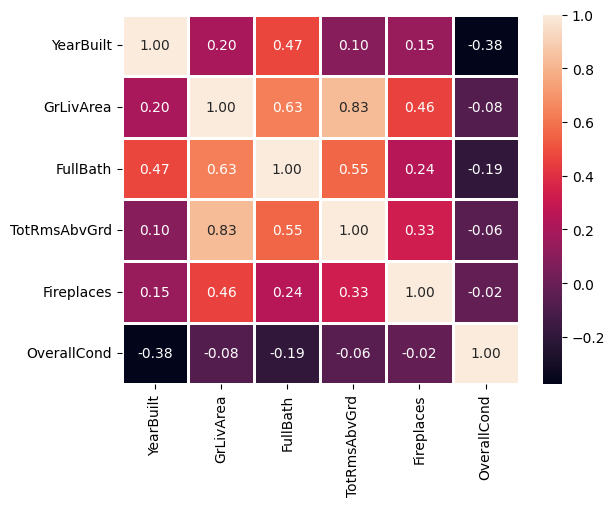

In [30]:
num_sel_corr = num_selection.corr()

sns.heatmap(num_sel_corr, annot=True, linewidths=0.8, fmt='.2f')

array([[<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'GrLivArea'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'TotRmsAbvGrd'}>],
       [<Axes: title={'center': 'Fireplaces'}>,
        <Axes: title={'center': 'OverallCond'}>]], dtype=object)

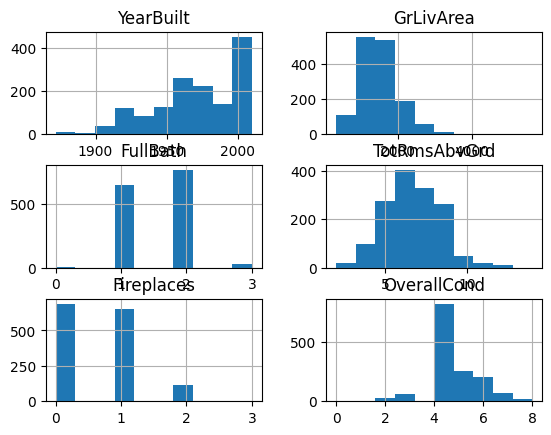

In [31]:
num_selection.hist()

In [32]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
dist_trans = log_transformer.transform(num_selection[['YearBuilt', 'GrLivArea']])

array([[<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'GrLivArea'}>]], dtype=object)

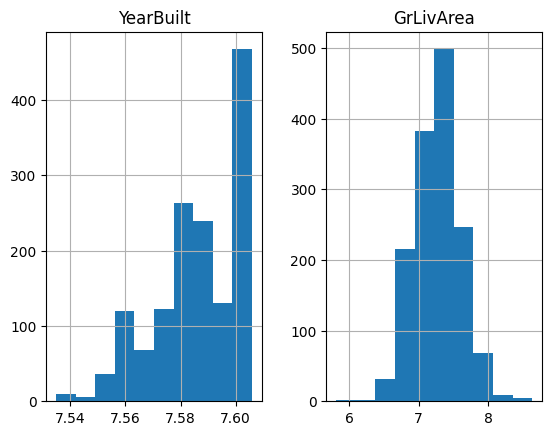

In [33]:
dist_trans.hist()

# Обработка категориальных признаков

In [34]:
num_selection.columns

Index(['YearBuilt', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces',
       'OverallCond'],
      dtype='object')

In [35]:
# Отберём категориальные признаки
cat_selection = cat_iowa[['Heating', 'BldgType', 'KitchenQual', 'Functional', 'SaleType', 'SaleCondition']]
cat_selection.head()

,Heating,BldgType,KitchenQual,Functional,SaleType,SaleCondition
0,GasA,1Fam,Gd,Typ,WD,Normal
1,GasA,1Fam,TA,Typ,WD,Normal
2,GasA,1Fam,Gd,Typ,WD,Normal
3,GasA,1Fam,Gd,Typ,WD,Abnorml
4,GasA,1Fam,Gd,Typ,WD,Normal


In [36]:
# Обработаем категориальные признаки
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
cat_encoder = ohe.fit(cat_selection)

cat_df = pd.DataFrame(cat_encoder.transform(cat_selection).toarray(), columns=cat_encoder.get_feature_names_out())

# Итоговый пайплайн обработки

In [124]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config

# Строим пайплайны для каждого случая
num_pipeline = Pipeline([
    ('standardize', StandardScaler(with_mean=False))
])

ordinal_pipeline = Pipeline([
    ('ordinal_encoding', OrdinalEncoder()),
    ('standardize', StandardScaler(with_mean=False)),
])

log_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log, feature_names_out='one-to-one')),
    ('standardize', StandardScaler(with_mean=False)),
])

onehot_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
    ('standardize', StandardScaler(with_mean=False)),
])

# Отбираем колонки для обработки
num_col = num_selection[['FullBath', 'TotRmsAbvGrd', 'Fireplaces']].columns.to_list()
cat_num = num_selection[['OverallCond']].columns.to_list()
log_num = num_selection[['GrLivArea', 'YearBuilt']].columns.to_list()
cat_col = cat_selection.columns.to_list()

# Выстраиваем общий пайплайн и объединяем в датафрейм
preprocessing = ColumnTransformer([
    ('ordinal', ordinal_pipeline, cat_num),
    ('log', log_pipeline, log_num),
    ('1hot', onehot_pipeline, cat_col),
    ('num', num_pipeline, num_col),
])

preprocessing

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('ordinal_encoding',
                                                  OrdinalEncoder()),
                                                 ('standardize',
                                                  StandardScaler(with_mean=False))]),
                                 ['OverallCond']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('standardize',
                                                  StandardScaler(with_mean=False))]),
                                 ['GrLivArea', 'YearBuilt']),
                                ('1hot',
                                 Pipeline(steps=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('standardize',
                                                  StandardScaler(with_mean=False))]),
                                 ['Heating', 'BldgType', 'KitchenQual',
                                  'Functional', 'SaleType', 'SaleCondition']),
                                ('num',
                                 Pipeline(steps=[('standardize',
                                                  StandardScaler(with_mean=False))]),
                                 ['FullBath', 'TotRmsAbvGrd', 'Fireplaces'])])

In [125]:
iowa_prepared = preprocessing.fit_transform(iowa_train)
iowa_prepared.shape

(1460, 43)

# Выбор и обучение моделей

In [126]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

In [127]:
# Отделим ID
X = iowa_train.drop(['SalePrice', 'Id'], axis=1)
y = iowa_train['SalePrice']
test_ids = iowa_test['Id']
X_test = iowa_test.drop(['Id'], axis=1)

<Axes: >

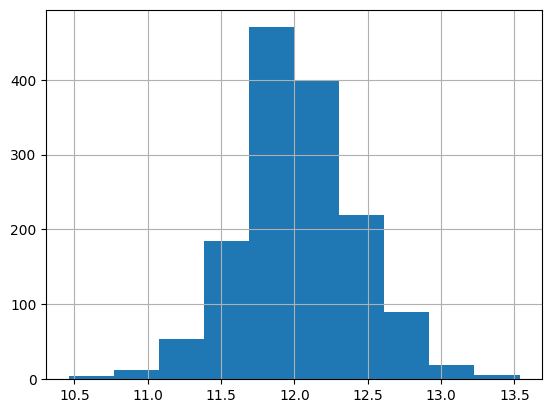

In [128]:
# Логарифмируем таргет
y_log = np.log(y)
y_log.hist()

In [129]:
# Линейная модель
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(iowa_train, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal_encoding',
                                                                   OrdinalEncoder()),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['OverallCond']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]...
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Heating', 'BldgType',
                                                   'KitchenQual', 'Functional',
                                                   'SaleType',
                                                   'SaleCondition']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['FullBath', 'TotRmsAbvGrd',
                                                   'Fireplaces'])])),
                ('linearregression', LinearRegression())])

In [130]:
iowa_pred_lin = lin_reg.predict(iowa_train)

In [132]:
lin_rmse = root_mean_squared_error(y, iowa_pred_lin)
lin_rmse

39080.41553527197

In [133]:
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor())
tree_reg.fit(iowa_train, y_log)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('ordinal_encoding',
                                                                   OrdinalEncoder()),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['OverallCond']),
                                                 ('log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]...
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Heating', 'BldgType',
                                                   'KitchenQual', 'Functional',
                                                   'SaleType',
                                                   'SaleCondition']),
                                                 ('num',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['FullBath', 'TotRmsAbvGrd',
                                                   'Fireplaces'])])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [134]:
iowa_pred_tree = tree_reg.predict(iowa_train)
tree_rmse_log = root_mean_squared_error(y, iowa_pred_tree)
tree_rmse_log

197572.4092651482

In [135]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, iowa_train, y, scoring='neg_root_mean_squared_error', cv=10)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", l

In [136]:
pd.Series(tree_rmses).describe()

,0
count,9.000000
mean,45795.192994
std,11501.781814
min,33039.709066
25%,39285.522159
50%,42051.638549
75%,51252.212217
max,63954.780568


In [137]:
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
# forest_reg.fit(iowa_train, y)
# forest_reg.predict(iowa_train)

forest_rmses = -cross_val_score(forest_reg, iowa_train, y, scoring='neg_root_mean_squared_error', cv=10)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 242, in _get_response_values
    y_pred, pos_label = prediction_method(X), None
                        ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", l

In [138]:
pd.Series(forest_rmses).describe()

,0
count,9.000000
mean,35713.443712
std,9706.423325
min,26020.946340
25%,29218.118026
50%,29373.109399
75%,44860.606620
max,51839.724390


In [139]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [10, 50, 100],
    'model__max_features': ['log2', 'sqrt'],
    'model__max_depth': [5, 15],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 3],
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')

In [140]:
grid_search.fit(iowa_train, y)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('ordinal',
                                                                         Pipeline(steps=[('ordinal_encoding',
                                                                                          OrdinalEncoder()),
                                                                                         ('standardize',
                                                                                          StandardScaler(with_mean=False))]),
                                                                         ['OverallCond']),
                                                                        ('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log'>)),
                                                                                         ('standardize',
                                                                                          StandardS...
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler(with_mean=False))]),
                                                                         ['FullBath',
                                                                          'TotRmsAbvGrd',
                                                                          'Fireplaces'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'model__max_depth': [5, 15],
                         'model__max_features': ['log2', 'sqrt'],
                         'model__min_samples_leaf': [1, 3],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [141]:
final_model = grid_search.best_estimator_

In [142]:
X_test['SaleType'].fillna(value=X_test['SaleType'].mode, inplace=True)
X_test['LotFrontage'].fillna(value=X_test['LotFrontage'].mode, inplace=True)
X_test['MSZoning'].fillna(value=X_test['MSZoning'].mode, inplace=True)

/tmp/ipython-input-1661759518.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<bound method Series.mode of 0        80.0
1        81.0
2        74.0
3        78.0
4        43.0
        ...  
1454     21.0
1455     21.0
1456    160.0
1457     62.0
1458     74.0
Name: LotFrontage, Length: 1459, dtype: float64>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  X_test['LotFrontage'].fillna(value=X_test['LotFrontage'].mode, inplace=True)


In [143]:
X_test.isna().sum()

,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
...,...
MiscVal,0
MoSold,0
YrSold,0
SaleType,0


In [150]:
sale_price = pd.DataFrame(final_model.predict(X_test), columns=['SalePrice'])

In [151]:
sample_sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [152]:
submission = pd.concat([test_ids, sale_price], axis=1)
submission.head()

,Id,SalePrice
0,1461,132336.275828
1,1462,131889.689993
2,1463,184169.590383
3,1464,214286.220987
4,1465,196803.097277


In [156]:
submission.to_csv('iowa_housing_sub.csv', index=False)

In [157]:
!kaggle competitions submit -c home-data-for-ml-course -f iowa_housing_sub.csv -m "Message"

100% 33.8k/33.8k [00:00<00:00, 62.4kB/s]
Successfully submitted to Housing Prices Competition for Kaggle Learn Users